In [2]:
!pip install PyGithub sentence-transformers scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [3]:
from github import Github

# Use your token here
###
g = Github(GITHUB_TOKEN)
user = g.get_user()
print(f"Authenticated as: {user.login}")



Authenticated as: Mkashaaf11


Content Based Filtering

In [4]:
user_repos = list(user.get_repos())
languages = set()

for repo in user_repos:
    try:
        if repo.language:
            languages.add(repo.language)
    except:
        continue

print(f"Languages used by the user: {languages}")


Languages used by the user: {'Jupyter Notebook', 'HCL', 'JavaScript', 'C#', 'HTML', 'Shell', 'EJS', 'Dockerfile', 'Python', 'TypeScript'}


In [5]:
from tqdm import tqdm

top_repos = []
seen_repo_ids = set()

for lang in languages:
    query = f"language:{lang} stars:>100"
    results = g.search_repositories(query=query, sort='stars', order='desc')
    for repo in results[:30]:  # Adjust to control how many per language
        if repo.id not in seen_repo_ids:
            top_repos.append(repo)
            seen_repo_ids.add(repo.id)
        if len(top_repos) >= 100:
            break
    if len(top_repos) >= 100:
        break

print(f"Collected {len(top_repos)} repositories for recommendation pool.")


Collected 100 repositories for recommendation pool.


In [6]:
readmes = []
repo_meta = []

for repo in tqdm(top_repos):
    try:
        readme = repo.get_readme()
        content = readme.decoded_content.decode()
        readmes.append(content)
        repo_meta.append({
            "name": repo.full_name,
            "url": repo.html_url,
            "description": repo.description or "",
            "language": repo.language,
            "topics": repo.get_topics()
        })
    except:
        continue

print(f"Readmes fetched: {len(readmes)}")


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]

Readmes fetched: 100


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(readmes)

bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert_model.encode(readmes, show_progress_bar=True)

# Combine vectors
combined_vectors = np.hstack([tfidf_matrix.toarray(), bert_embeddings])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
# Get README content of user's own repos
user_readmes = []
for repo in user_repos:
    try:
        readme = repo.get_readme()
        user_readmes.append(readme.decoded_content.decode())
    except:
        continue

# Get average user embedding
if not user_readmes:
    raise ValueError("User has no accessible READMEs to base recommendations on.")

user_tfidf = tfidf.transform(user_readmes).toarray()
user_bert = bert_model.encode(user_readmes)

user_vector = np.mean(np.hstack([user_tfidf, user_bert]), axis=0).reshape(1, -1)

# Cosine similarity
similarities = cosine_similarity(user_vector, combined_vectors)[0]
top_indices = np.argsort(similarities)[::-1][:10]


In [9]:
print("🔍 Top Recommended Repositories:\n")
for idx in top_indices:
    meta = repo_meta[idx]
    print(f"- {meta['name']} ({meta['language']})")
    print(f"  {meta['url']}")
    print(f"  📄 {meta['description']}\n")


🔍 Top Recommended Repositories:

- expressjs/express (JavaScript)
  https://github.com/expressjs/express
  📄 Fast, unopinionated, minimalist web framework for node.

- SadServers/sadservers (HCL)
  https://github.com/SadServers/sadservers
  📄 SadServers: Linux & DevOps Troubleshooting Scenarios SaaS

- antonputra/tutorials (HCL)
  https://github.com/antonputra/tutorials
  📄 DevOps Tutorials

- crimx/ext-saladict (TypeScript)
  https://github.com/crimx/ext-saladict
  📄 🥗 All-in-one professional pop-up dictionary and page translator which supports multiple search modes, page translations, new word notebook and PDF selection searching.

- AdminTurnedDevOps/DevOps-The-Hard-Way-AWS (HCL)
  https://github.com/AdminTurnedDevOps/DevOps-The-Hard-Way-AWS
  📄 This repository contains free labs for setting up an entire workflow and DevOps environment from a real-world perspective in AWS

- open-webui/open-webui (JavaScript)
  https://github.com/open-webui/open-webui
  📄 User-friendly AI Interface 

Collaborative Filtering

In [12]:
from github import GithubException

In [20]:
# Assume top_repos, similarities, combined_vectors are from earlier code
user_item_matrix = {}
interaction_weights = {
    'star': 1.0,
    'watch': 2.0,
    'fork': 3.0,
    'contributor': 5.0
}

# Limit the number of users fetched per interaction type to avoid rate limit issues
MAX_USERS_PER_TYPE = 100  # Adjust based on your needs and API limits

for repo in tqdm(top_repos, desc="Collecting interactions"):
    repo_name = repo.full_name
    try:
        # Get stargazers (limit to first MAX_USERS_PER_TYPE)
        stargazers = repo.get_stargazers()[:MAX_USERS_PER_TYPE]
        for user in stargazers:
            if user.login not in user_item_matrix:
                user_item_matrix[user.login] = {}
            user_item_matrix[user.login][repo_name] = user_item_matrix[user.login].get(repo_name, 0) + interaction_weights['star']

        # Get watchers/subscribers
        watchers = repo.get_subscribers()[:MAX_USERS_PER_TYPE]
        for user in watchers:
            if user.login not in user_item_matrix:
                user_item_matrix[user.login] = {}
            user_item_matrix[user.login][repo_name] = user_item_matrix[user.login].get(repo_name, 0) + interaction_weights['watch']

        # Get forkers
        forks = repo.get_forks()[:MAX_USERS_PER_TYPE]
        for fork in forks:
            user = fork.owner
            if user and user.login:
                if user.login not in user_item_matrix:
                    user_item_matrix[user.login] = {}
                user_item_matrix[user.login][repo_name] = user_item_matrix[user.login].get(repo_name, 0) + interaction_weights['fork']

        # Get contributors
        contributors = repo.get_contributors()[:MAX_USERS_PER_TYPE]
        for user in contributors:
            if user.login not in user_item_matrix:
                user_item_matrix[user.login] = {}
            user_item_matrix[user.login][repo_name] = user_item_matrix[user.login].get(repo_name, 0) + interaction_weights['contributor']

    except GithubException as e:
        print(f"Error processing {repo_name}: {e}")
        continue

In [21]:
# Step 2: Build user-item matrix
import pandas as pd
df = pd.DataFrame(user_item_matrix).T.fillna(0)

In [16]:
user = g.get_user()
for repo in top_repos[:5]:  # Star 5 repos
    try:
        user.add_to_starred(repo)
        print(f"Starred {repo.full_name}")
    except Exception as e:
        print(f"Error starring {repo.full_name}: {e}")

Starred d2l-ai/d2l-zh
Starred dair-ai/Prompt-Engineering-Guide
Starred mlabonne/llm-course
Starred facebookresearch/segment-anything
Starred jakevdp/PythonDataScienceHandbook


In [18]:
for repo in top_repos[23:44]:
    try:
        user.add_to_starred(repo)
        print(f"Starred {repo.full_name}")
        user.add_to_subscriptions(repo)
        print(f"Subscribed to {repo.full_name}")
    except GithubException as e:
        print(f"Error processing {repo.full_name}: {e}")

Starred ctgk/PRML
Subscribed to ctgk/PRML
Starred dive-into-machine-learning/dive-into-machine-learning
Subscribed to dive-into-machine-learning/dive-into-machine-learning
Starred unicodeveloper/awesome-nextjs
Subscribed to unicodeveloper/awesome-nextjs
Starred GoogleCloudPlatform/generative-ai
Subscribed to GoogleCloudPlatform/generative-ai
Starred aws/amazon-sagemaker-examples
Subscribed to aws/amazon-sagemaker-examples
Starred fastai/numerical-linear-algebra
Subscribed to fastai/numerical-linear-algebra
Starred AccumulateMore/CV
Subscribed to AccumulateMore/CV
Starred ChristianLempa/boilerplates
Subscribed to ChristianLempa/boilerplates
Starred terraform-aws-modules/terraform-aws-eks
Subscribed to terraform-aws-modules/terraform-aws-eks
Starred chef/bento
Subscribed to chef/bento
Starred antonputra/tutorials
Subscribed to antonputra/tutorials
Starred iam-veeramalla/Azure-zero-to-hero
Subscribed to iam-veeramalla/Azure-zero-to-hero
Starred terraform-aws-modules/terraform-aws-vpc
Subs

In [19]:
for repo in top_repos[7:9]:
    try:
        user.create_fork(repo)  # Fork the repo
        print(f"Forked {repo.full_name}")
    except GithubException as e:
        print(f"Error processing {repo.full_name}: {e}")

Forked donnemartin/data-science-ipython-notebooks
Forked d2l-ai/d2l-en


In [22]:
# Step 3: Get target user's interactions
target_user = g.get_user().login  # Authenticated user
if target_user not in df.index:
    print("Target user has no interactions. Falling back to content-based recommendations.")
    hybrid_scores = similarities
else:
    # Step 4: Compute user-based CF similarities
    target_user_vector = df.loc[target_user].values.reshape(1, -1)
    cf_similarities = cosine_similarity(target_user_vector, df.values)[0]

    # Map user similarities to repository scores
    repo_scores = df.T @ cf_similarities  # Weighted sum of interactions by similar users
    repo_scores = repo_scores / (np.max(repo_scores) + 1e-10)  # Normalize to [0, 1]

    # Ensure repo_scores aligns with top_repos
    cf_scores = np.zeros(len(top_repos))
    for i, repo in enumerate(top_repos):
        if repo.full_name in repo_scores:
            cf_scores[i] = repo_scores[repo.full_name]

    # Step 5: Hybrid recommendation (combine content-based and CF)
    hybrid_scores = 0.6 * similarities + 0.4 * cf_scores  # Adjust weights as needed


In [29]:
#Get top 10 recommendations (collaborative)
top_cf_indices = np.argsort(cf_scores)[::-1][:10]
recommended_repos_cf = [
    {
        'name': top_repos[i].full_name,
        'url': top_repos[i].html_url,
        'description': top_repos[i].description or '',
        'language': top_repos[i].language,
        'score': cf_scores[i]
    }
    for i in top_cf_indices
]

In [30]:
# Print recommendations (collaborative)
print("Top 10 Recommended Repositories:")
for repo in recommended_repos_cf:
    print(f"- {repo['name']} ({repo['language']}): {repo['description']} (Score: {repo['score']:.4f})")
    print(f"  URL: {repo['url']}")

Top 10 Recommended Repositories:
- d2l-ai/d2l-en (Python): Interactive deep learning book with multi-framework code, math, and discussions. Adopted at 500 universities from 70 countries including Stanford, MIT, Harvard, and Cambridge. (Score: 1.0000)
  URL: https://github.com/d2l-ai/d2l-en
- terraform-aws-modules/terraform-aws-eks (HCL): Terraform module to create Amazon Elastic Kubernetes (EKS) resources 🇺🇦 (Score: 0.7237)
  URL: https://github.com/terraform-aws-modules/terraform-aws-eks
- terraform-aws-modules/terraform-aws-vpc (HCL): Terraform module to create AWS VPC resources 🇺🇦 (Score: 0.6965)
  URL: https://github.com/terraform-aws-modules/terraform-aws-vpc
- aws-ia/terraform-aws-eks-blueprints (HCL): Configure and deploy complete EKS clusters. (Score: 0.6621)
  URL: https://github.com/aws-ia/terraform-aws-eks-blueprints
- antonputra/tutorials (HCL): DevOps Tutorials (Score: 0.6363)
  URL: https://github.com/antonputra/tutorials
- kube-hetzner/terraform-hcloud-kube-hetzner (HCL)

In [23]:
# Step 6: Get top 10 recommendations
top_indices = np.argsort(hybrid_scores)[::-1][:10]
recommended_repos = [
    {
        'name': top_repos[i].full_name,
        'url': top_repos[i].html_url,
        'description': top_repos[i].description or '',
        'language': top_repos[i].language,
        'score': hybrid_scores[i]
    }
    for i in top_indices
]

In [24]:
# Print recommendations
print("Top 10 Recommended Repositories:")
for repo in recommended_repos:
    print(f"- {repo['name']} ({repo['language']}): {repo['description']} (Score: {repo['score']:.4f})")
    print(f"  URL: {repo['url']}")

Top 10 Recommended Repositories:
- d2l-ai/d2l-en (Python): Interactive deep learning book with multi-framework code, math, and discussions. Adopted at 500 universities from 70 countries including Stanford, MIT, Harvard, and Cambridge. (Score: 0.4611)
  URL: https://github.com/d2l-ai/d2l-en
- terraform-aws-modules/terraform-aws-eks (HCL): Terraform module to create Amazon Elastic Kubernetes (EKS) resources 🇺🇦 (Score: 0.4007)
  URL: https://github.com/terraform-aws-modules/terraform-aws-eks
- antonputra/tutorials (HCL): DevOps Tutorials (Score: 0.3829)
  URL: https://github.com/antonputra/tutorials
- github-aws-runners/terraform-aws-github-runner (HCL): Terraform module for scalable GitHub action runners on AWS (Score: 0.3596)
  URL: https://github.com/github-aws-runners/terraform-aws-github-runner
- aws-ia/terraform-aws-eks-blueprints (HCL): Configure and deploy complete EKS clusters. (Score: 0.3562)
  URL: https://github.com/aws-ia/terraform-aws-eks-blueprints
- terraform-aws-modules/t

In [25]:
import pickle
import os
from google.colab import drive

# Mount Google Drive for persistent storage (optional)
drive.mount('/content/drive')  # Authorize Colab to access your Drive

# Assume previous data: top_repos, repo_meta, tfidf_matrix, bert_embeddings, combined_vectors, user_readmes, user_tfidf, user_bert, user_vector, user_item_matrix

# Create a directory in Colab or Drive
os.makedirs('/content/data', exist_ok=True)  # Local Colab storage
os.makedirs('/content/drive/My Drive/colab_data', exist_ok=True)  # Google Drive

# Save repository data
with open('/content/data/repo_data.pkl', 'wb') as f:
    pickle.dump({
        'top_repos': top_repos,
        'repo_meta': repo_meta,
        'tfidf_matrix': tfidf_matrix,
        'bert_embeddings': bert_embeddings,
        'combined_vectors': combined_vectors
    }, f)

# Save user data
with open('/content/data/user_data.pkl', 'wb') as f:
    pickle.dump({
        'user_readmes': user_readmes,
        'user_tfidf': user_tfidf,
        'user_bert': user_bert,
        'user_vector': user_vector
    }, f)

# Save user-item matrix
with open('/content/data/user_item_matrix.pkl', 'wb') as f:
    pickle.dump(user_item_matrix, f)

# Optionally save to Google Drive for persistence
with open('/content/drive/My Drive/colab_data/repo_data.pkl', 'wb') as f:
    pickle.dump({
        'top_repos': top_repos,
        'repo_meta': repo_meta,
        'tfidf_matrix': tfidf_matrix,
        'bert_embeddings': bert_embeddings,
        'combined_vectors': combined_vectors
    }, f)
with open('/content/drive/My Drive/colab_data/user_data.pkl', 'wb') as f:
    pickle.dump({
        'user_readmes': user_readmes,
        'user_tfidf': user_tfidf,
        'user_bert': user_bert,
        'user_vector': user_vector
    }, f)
with open('/content/drive/My Drive/colab_data/user_item_matrix.pkl', 'wb') as f:
    pickle.dump(user_item_matrix, f)

# Verify files in Colab
print("Files in /content/data:", os.listdir('/content/data'))
print("Files in Drive:", os.listdir('/content/drive/My Drive/colab_data'))

Mounted at /content/drive
Files in /content/data: ['user_item_matrix.pkl', 'user_data.pkl', 'repo_data.pkl']
Files in Drive: ['repo_data.pkl', 'user_data.pkl', 'user_item_matrix.pkl']


User Similarity Heatmap

<ipython-input-31-f86c265f3dff>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='similarity', y='user', data=similarity_df.head(20), palette='viridis')


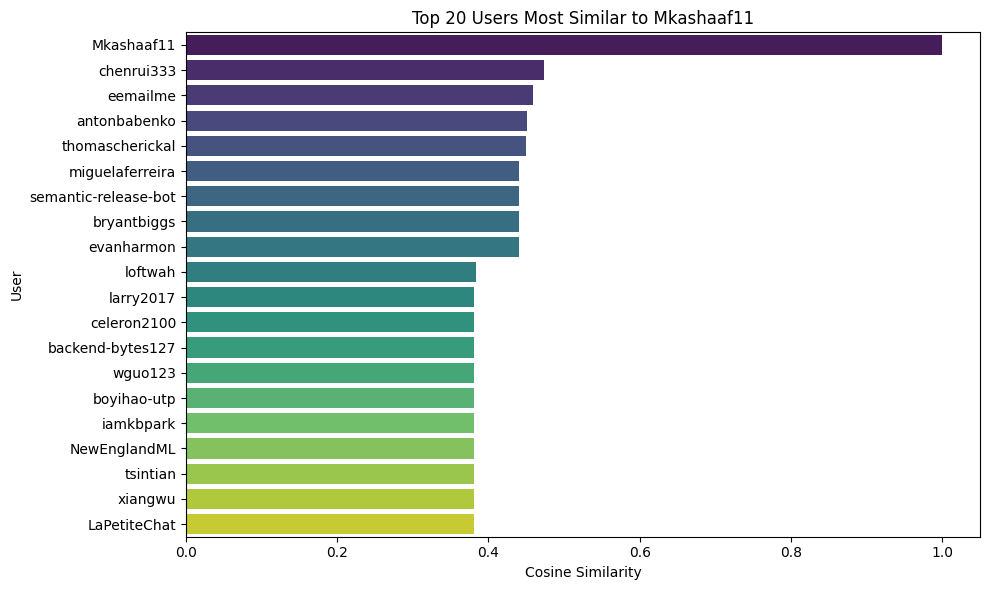

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a similarity dataframe
similarity_df = pd.DataFrame({
    'user': df.index,
    'similarity': cf_similarities
}).sort_values(by='similarity', ascending=False)

# Plot top 20 most similar users
plt.figure(figsize=(10, 6))
sns.barplot(x='similarity', y='user', data=similarity_df.head(20), palette='viridis')
plt.title(f"Top 20 Users Most Similar to {target_user}")
plt.xlabel("Cosine Similarity")
plt.ylabel("User")
plt.tight_layout()
plt.show()


User-Item Matrix Heatmap

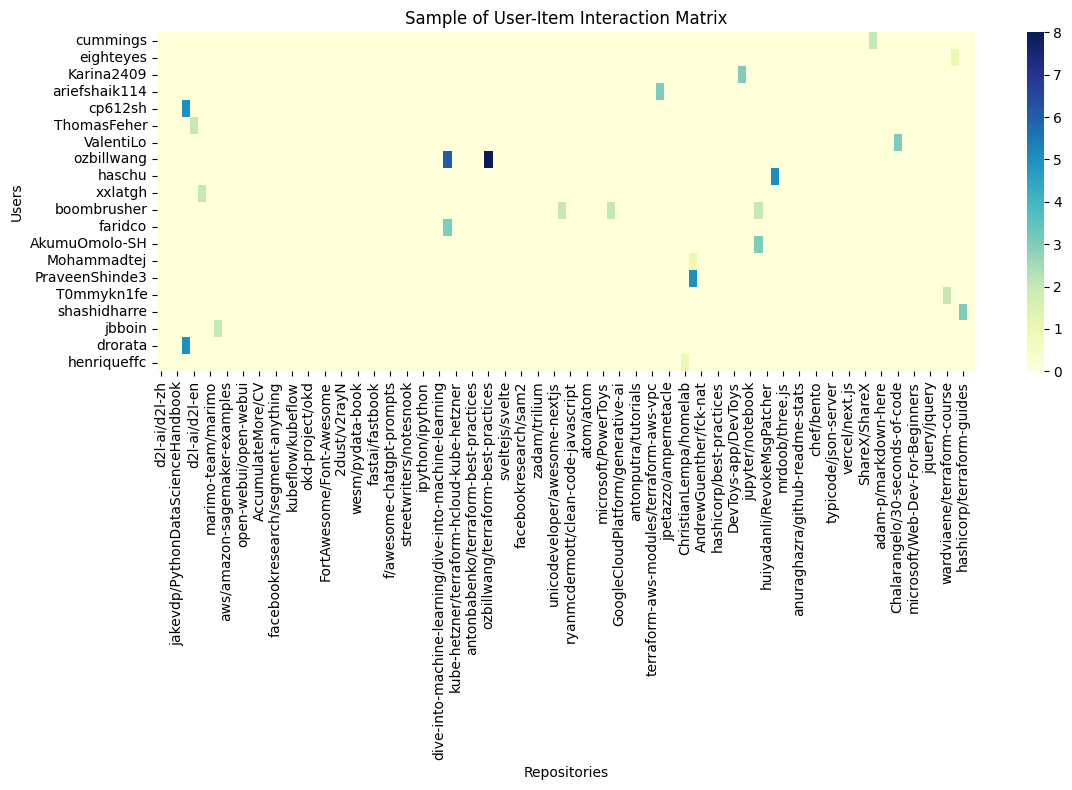

In [32]:
sample_users = df.sample(n=20, random_state=42)
plt.figure(figsize=(12, 8))
sns.heatmap(sample_users, cmap="YlGnBu", cbar=True)
plt.title("Sample of User-Item Interaction Matrix")
plt.xlabel("Repositories")
plt.ylabel("Users")
plt.tight_layout()
plt.show()
